In [1]:
import sys
import os
import matplotlib.gridspec as gridspec
import matplotlib.dates as mdates
import string
from mpasanalysis import *
%matplotlib inline

In [2]:
def format_m_to_km(value, tick_number):
    return value/1000.
    
def plot_snapshot(mpas_data, aux_data, varname, tidx, name=None, units=None, celllist=None, levels=None, \
                  savefig=False, figdir=None, dcell=0, **kwargs):
    # parameters
    if name is None:
        name = varname
    zidx = 0
    position = 'cell'
    
    # alphabet
    alphabet = list(string.ascii_lowercase)
    # list of cells
    if celllist is None:
        lesCell = mpas_data.get_domain(varname='lesCell')
        indexToCellID = mpas_data.load().variables['indexToCellID'][:]
        idx = (lesCell.data == 1)
        idxLESCells = indexToCellID[idx]
    else:
        idxLESCells = celllist
    # get x and y locations of cells    
    xCell = mpas_data.load().variables['xCell'][:]
    yCell = mpas_data.load().variables['yCell'][:]
    xLESCells = xCell[idxLESCells-1]
    yLESCells = yCell[idxLESCells-1]
    # print cells
    for i in np.arange(len(idxLESCells)):
        print('Cell {:s} {:6d}: {:10.2f}, {:10.2f}'.format(alphabet[i], idxLESCells[i], \
                                                           xLESCells[i], yLESCells[i]))
    
    # get dimensions
    npfl = len(idxLESCells)
    assert npfl == 4, 'Wrong number of profiles'
    nr = 4
    nc = nr + 3

    # initialize figure and axes
    fig = plt.figure(figsize=[20,8], constrained_layout=False)
    gs = fig.add_gridspec(nrows=nr, ncols=nc, left=0.07, bottom=0.1, top=0.95, hspace=0.3, wspace=0.4)
    axarr = []
    ax = fig.add_subplot(gs[:nr-1,2:-2])
    axarr.append(ax)
    ax = fig.add_subplot(gs[-1,2:-2])
    axarr.append(ax)
    for i in np.arange(nr):
        if i%2 == 0: 
            ax = fig.add_subplot(gs[i,:2])
            axarr.append(ax)
        else:
            ax = fig.add_subplot(gs[i,:1])
            axarr.append(ax)
            ax = fig.add_subplot(gs[i,1:2])
            axarr.append(ax)
    for i in np.arange(nr):
        if i%2 == 0:
            ax = fig.add_subplot(gs[i, -2:])
            axarr.append(ax)
        else:
            ax = fig.add_subplot(gs[i, -2:-1])
            axarr.append(ax)
            ax = fig.add_subplot(gs[i, -1:])
            axarr.append(ax)
    
    # plot snapshot
    data = mpas_data.get_domain(varname=varname, position=position, name=name, units=units, tidx=tidx)
    zmax = 0
#     zmin = data.z.min()
    zmin = -100
    
    # get time
    time_str = datime[tidx].strftime('%Y-%m-%d_%H:%M:%S')
    print(time_str)
    
    # xy view
    im = data.plot_yx(axis=axarr[0], ptype='contourf', levels=levels, zidx=zidx, title=time_str, \
                      add_colorbar=False , **kwargs)
    axarr[0].set_aspect(1)
    axarr[0].set_ylim([10000, 50000])
    axarr[0].xaxis.set_major_formatter(plt.FuncFormatter(format_m_to_km))
    axarr[0].yaxis.set_major_formatter(plt.FuncFormatter(format_m_to_km))
    axarr[0].set_xlabel('y (km)')
    axarr[0].set_ylabel('x (km)')

    # label locations
    for i in np.arange(npfl):
        xx = xLESCells[i]
        yy = yLESCells[i]
        axarr[0].plot(yy, xx, '.', color='k')
        axarr[0].text(yy, xx+1000, alphabet[i], fontsize=12, color='black', va='top', ha='center')
    axarr[0].invert_yaxis()

    # yz mean
    data.plot_yz_mean(axis=axarr[1],ptype='contourf', levels=levels, title='', add_colorbar=False, **kwargs)
    axarr[1].set_ylabel('')
    axarr[1].set_ylim([zmin, zmax])
    axarr[1].xaxis.set_major_formatter(plt.FuncFormatter(format_m_to_km))
    axarr[1].set_xlabel('y (km)')
    
    # index of zoom-in period
    tidxs = -24
    
    # full time series of profiles
    for i in np.arange(npfl):
        j = 2+i*3
        idx = idxLESCells[i]-1+dcell 
        pfl = mpas_data.get_profile(varname=varname, idx=idx) 
        pfl.plot(axis=axarr[j], levels=levels)
        axarr[j].vlines(x=pfl.time[tidx], ymin=zmin, ymax=zmax, color='white') 
        line = axarr[j].hlines(y=zmin-8, xmin=pfl.time[tidxs], xmax=pfl.time[-1], color='black', linewidth=2) 
        line.set_clip_on(False)
        axarr[j].text(0.02, 0.94, '('+alphabet[i]+')', transform=axarr[j].transAxes, \
                         fontsize=12, color='black', fontweight='bold', va='top')
        axarr[j].set_ylim([zmin, zmax])
        axarr[j].xaxis.set_label_position('top')
        axarr[j].xaxis.tick_top()
        axarr[j].xaxis.set_major_formatter(mdates.DateFormatter("%m-%d"))
#         for tick in axarr[j].get_xticklabels():
#             tick.set_rotation(45)
#             tick.set_ha('left')
        if i%2 == 1:
            plt.setp(axarr[j].get_xticklabels(), visible=False)
        if i >= 2:
            axarr[j].set_ylabel('')
    
    # last 3 days of the profiles
    for i in np.arange(npfl):
        j = 2+i*3+1
        idx = idxLESCells[i]-1+dcell
        pfl = mpas_data.get_profile(varname=varname, idx=idx, tidx_start=tidxs) 
        pfl.plot(axis=axarr[j], levels=levels)
        axarr[j].vlines(x=pfl.time[tidx], ymin=zmin, ymax=zmax, color='white') 
        axarr[j].set_ylim([zmin, zmax])
        for tick in axarr[j].get_xticklabels():
            tick.set_rotation(45)
            tick.set_ha('right')
        if i%2 == 0:
            plt.setp(axarr[j].get_xticklabels(), visible=False)
        if i >= 2:
            axarr[j].set_ylabel('')
            
    # last 3 days of the profiles - LES
    for i in np.arange(npfl):
        j = 2+i*3+2
        idx = idxLESCells[i]-1
        les_file = root_dir+'' 
        pfl = aux_data.get_profile(varname=varname+'LES', idx=idx, position='cellLES') 
        pfl.plot(axis=axarr[j], levels=levels)
        axarr[j].vlines(x=pfl.time[tidx], ymin=zmin, ymax=zmax, color='white') 
        axarr[j].set_ylim([zmin, zmax])
        axarr[j].set_ylabel('')
        for tick in axarr[j].get_xticklabels():
            tick.set_rotation(45)
            tick.set_ha('right')
        if i%2 == 0:
            plt.setp(axarr[j].get_xticklabels(), visible=False)
            
            
    # colorbar
    plt.subplots_adjust(right=0.9)
    cax = plt.axes([0.84, 0.25, 0.1, 0.5])
    cax.set_visible(False)
    cb = plt.colorbar(im, ax=cax)
    cb.formatter.set_powerlimits((-2, 3))
    cb.update_ticks()
    cb.set_label(varname+'('+units+')')
    
    # horizontal colorbar
    figcb = plt.figure(figsize=[6,2])
    cax = plt.axes([0.05, 0.5, 0.9, 0.9])
    cax.set_visible(False)
    cb2 = plt.colorbar(im, ax=cax, orientation='horizontal')
    cb2.formatter.set_powerlimits((-2, 3))
    cb2.update_ticks()
    cb2.set_label(varname+'('+units+')')
    
    # save figures
    if savefig:
        assert figdir is not None, 'figdir required.'
#         figname = figdir+'/'+varname+'_pfl_{:04d}_offset{:d}.pdf'.format(tidx, dcell)
        figname = figdir+'/'+varname+'_pfl_{:04d}_coupled_vs_uncoupled.pdf'.format(tidx)
        fig.savefig(figname, dpi = 300)  
        figname = figdir+'/'+varname+'_pfl_{:04d}_coupled_vs_uncoupled_colorbar.pdf'.format(tidx)
        figcb.savefig(figname, dpi = 300)  

In [3]:
casename = 'sp_warm_filament'
aux_casename = 'sp_warm_filament_coupled'
root_dir = os.environ['HOME']+'/scratch/superparameterization/'+casename+'/output'
aux_root_dir = os.environ['HOME']+'/scratch/superparameterization/'+aux_casename+'/output'
data_file = root_dir+'/output.0001-01-01_00.00.00.all.nc'
kpp_data_file = aux_root_dir+'/KPP_test.0001-01-11_00.00.00.nc'
figdir = os.environ['HOME']+'/work/superParameterization/'+casename
mesh_file = data_file
kpp_mesh_file = kpp_data_file
os.makedirs(figdir, exist_ok=True)

In [4]:
mpas_data = MPASOData(filepath=data_file, filepath_mesh=mesh_file)
kpp_mpas_data = MPASOData(filepath=kpp_data_file, filepath_mesh=kpp_mesh_file)
xtime = chartostring(mpas_data.load().variables['xtime'][:])
datime = [datetime.strptime(x.strip().replace('0000', '0001'), '%Y-%m-%d_%H:%M:%S') for x in xtime]
ntime = len(datime)

In [5]:
lesCell = mpas_data.get_domain(varname='lesCell')
indexToCellID = mpas_data.load().variables['indexToCellID'][:]
xCell = mpas_data.load().variables['xCell'][:]
yCell = mpas_data.load().variables['yCell'][:]
alphabet = list(string.ascii_lowercase)

idx = (lesCell.data == 1)
tmp = indexToCellID[idx]
# idxLESCells = tmp[1:5]
idxLESCells = np.array([5809, 6672, 7237, 7741])
xLESCells = xCell[idxLESCells-1]
yLESCells = yCell[idxLESCells-1]
    
# print
for i in np.arange(len(idxLESCells)):
    print('Cell {:s} {:6d}: {:10.2f}, {:10.2f}'.format(alphabet[i], idxLESCells[i], xLESCells[i], yLESCells[i]))

Reading mesh data from /Users/qingli/scratch/superparameterization/sp_warm_filament/output/output.0001-01-01_00.00.00.all.nc
Cell a   5809:   29100.00,   25461.15
Cell b   6672:   43200.00,   29098.45
Cell c   7237:   21900.00,   31696.53
Cell d   7741:   36300.00,   33774.99


[15.25 15.3  15.35 15.4  15.45 15.5  15.55 15.6  15.65 15.7  15.75 15.8
 15.85 15.9  15.95 16.   16.01 16.02 16.03 16.04 16.05 16.06 16.07 16.08
 16.09 16.1  16.11 16.12 16.13 16.14 16.15 16.16 16.17 16.18 16.19 16.2
 16.21 16.22 16.23 16.24 16.25 16.26 16.27 16.28 16.29 16.3  16.31 16.32]
Cell a   5809:   29100.00,   25461.15
Cell b   6672:   43200.00,   29098.45
Cell c   7237:   21900.00,   31696.53
Cell d   7741:   36300.00,   33774.99
Reading mesh data from /Users/qingli/scratch/superparameterization/sp_warm_filament/output/output.0001-01-01_00.00.00.all.nc
0001-01-12_15:00:00
Average over x at 111 bins in y.


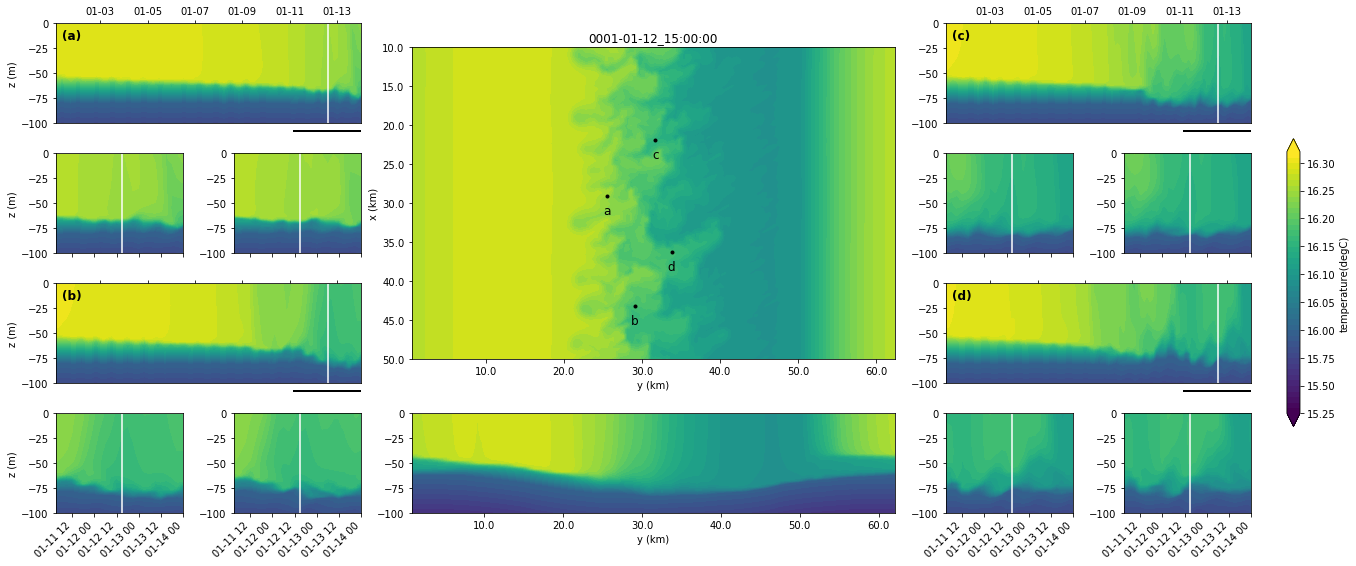

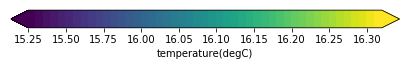

In [6]:
varname = 'temperature'
units = 'degC'
# levels=np.linspace(15.15,16.35,121)
levels1 = np.linspace(15.25, 16, 16)
levels2 = np.linspace(16.01, 16.32, 32)
levels = np.concatenate((levels1, levels2))
print(levels)
tidx = -12
plot_snapshot(mpas_data=mpas_data, aux_data=kpp_mpas_data, varname=varname, tidx=tidx, units=units, \
              celllist=idxLESCells, levels=levels, \
              savefig=True, figdir=figdir, dcell=0)